In [1]:
from rdkit import Chem
import psycopg2
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
import warnings
# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors import CalcMolDescriptors
import sys
sys.path.append('../..')
from carl import utils_carl
from carl.utils_carl import train_pred_xgboost_2d, getStatValues,density_plot, get_mdfps
from functools import reduce

In [2]:

# cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
# cur = cn.cursor()

# # Define the SQL query to perform the joins with schema qualification
# sql_query = '''
# SELECT cs_mdfps_schema.confid_data.conf_id AS confid,
#        public.conformers.molblock,
#        cs_mdfps_schema.experimental_data.vp_log10Pa
# FROM cs_mdfps_schema.confid_data
# INNER JOIN public.conformers
# ON cs_mdfps_schema.confid_data.conf_id = public.conformers.conf_id
# INNER JOIN cs_mdfps_schema.experimental_data
# ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
# WHERE cs_mdfps_schema.confid_data.confgen_uuid = '906589dd-76fa-4d7b-aa9f-1ee90abe3835';

# '''
# # Execute the SQL query
# cur.execute(sql_query)
# results = cur.fetchall()
# #print columns with index
# print('Columns:')
# for col in cur.description:
#     print(col)
# molblocks = [r[1] for r in results]
# mols = [Chem.MolFromMolBlock(m) for m in molblocks]
# mols = [Chem.AddHs(m) for m in mols]
# MolDescriptors_vectors = [list(CalcMolDescriptors(m).values()) for m in mols]


In [3]:
import sys
sys.path.append('../..')
from carl import utils_carl
from carl.utils_carl import train_pred_xgboost_2d, getStatValues,density_plot, get_mdfps
from functools import reduce

In [4]:
# #make dataframe of the moldescriptors
# df = pd.DataFrame(MolDescriptors_vectors)
# df.columns = list(CalcMolDescriptors(mols[0]).keys())
# df['vp'] = [r[2] for r in results]
# df['confid'] = [r[0] for r in results]
# df = df.set_index('confid')
# df = df.reset_index()

In [5]:
df = pd.read_csv('mdfp_and_rdkit_features_all_mols.csv')

In [6]:
params = {
    # Parameters that we are going to tune.
    'max_depth':3,
    'min_child_weight': 6,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    "objective" : 'reg:squarederror',
}
#load X features: carl/RDKit_2D_descriptors.pkl
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')
output_2d_only = train_pred_xgboost_2d(df,params=params,X_features=RDKit_feature_names,y_label='vp')
real_2d_only, prediction_2d_only = (reduce(lambda a,b : list(a)+list(b) , output_2d_only[0]), reduce(lambda a,b : list(a)+list(b), output_2d_only[1]))
mdfp_features_no_2d = ['water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
output_combined = train_pred_xgboost_2d(df,params=params,X_features=RDKit_feature_names+mdfp_features_no_2d,y_label='vp')
real_combined, prediction_combined = (reduce(lambda a,b : list(a)+list(b) , output_combined[0]), reduce(lambda a,b : list(a)+list(b), output_combined[1]))

Plot 1 Stats:
RMSE:  1.2240529735051782
MAE:  0.7530258437360301
R2:  0.8852345251786184
Plot 2 Stats:
RMSE:  1.2590723965498132
MAE:  0.7740378662771044
R2:  0.8786242264492747


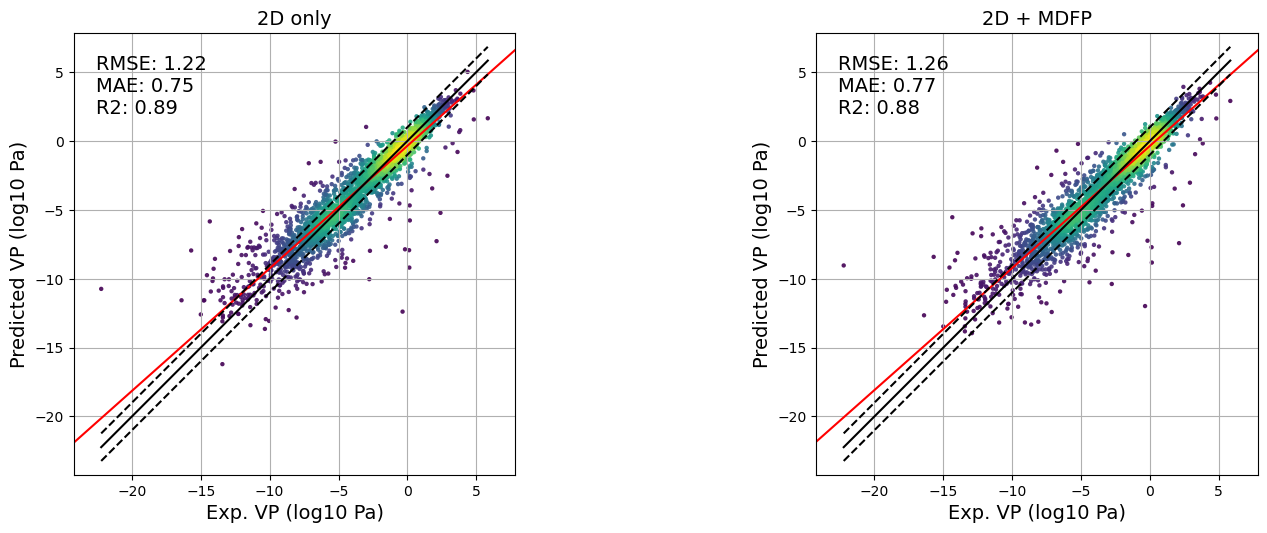

In [7]:
from carl.utils_carl import density_plot_multiple
density_plot_multiple(reals = [real_2d_only,real_combined],predictions=[prediction_2d_only,prediction_combined],titles = ['2D only','2D + MDFP'])

In [8]:
#okay, now I actually want to look at prediction error of only 2d vs only mdfp per mol, and look at the difference
params = { #hyperparameters optimized by ShuZe Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
import numpy as np
from sklearn.model_selection import GroupKFold, KFold
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
gkf = GroupKFold(n_splits=5)

# Create an empty list to store the indices of each fold
fold_indices = []
# Group the data by 'molregno'
groups = df['molregno']

# Iterate over each fold
for train_idx, test_idx in gkf.split(df, groups=groups):
    fold_indices.append((train_idx, test_idx))
mdfp_features_all = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']

y = df['vp']  
params = params
output = ([],[],[],[],[])
selection_2d_features = RDKit_feature_names

X_mdfp = df[mdfp_features_all]
X_mdfp = StandardScaler().fit_transform(X_mdfp)
X_2d = df[selection_2d_features]
X_2d = StandardScaler().fit_transform(X_2d)
y = df['vp']
# Iterate over each fold
for fold, (train_idx, test_idx) in enumerate(fold_indices):

    #get the train and test data
    X_train_mdfp = X_mdfp[train_idx]
    X_test_mdfp = X_mdfp[test_idx]
    X_train_2d = X_2d[train_idx]
    X_test_2d = X_2d[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]



    # Create DMatrix for training and testing
    dtrain_mdfp = xgb.DMatrix(X_train_mdfp, label=y_train)
    dtest_mdfp = xgb.DMatrix(X_test_mdfp, label=y_test)

    dtrain_2d = xgb.DMatrix(X_train_2d, label=y_train)
    dtest_2d = xgb.DMatrix(X_test_2d, label=y_test)


    model_mdfp = xgb.train(
        params,
        dtrain_mdfp,
        num_boost_round=999,
        evals=[(dtest_mdfp, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )

    model_2d = xgb.train(
        params,
        dtrain_2d,
        num_boost_round=999,
        evals=[(dtest_2d, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )
    pp_mdfp = model_mdfp.predict(dtest_mdfp)
    pp_2d = model_2d.predict(dtest_2d)

    output[0].append(y_test)
    output[1].append(pp_mdfp)
    molregnos_test = df['molregno'].iloc[test_idx]
    confids_test = df['confid'].iloc[test_idx]
    
    output[2].append(molregnos_test)
    output[3].append(confids_test)
    output[4].append(pp_2d)

    rmse_mdfp = np.sqrt(mean_squared_error(y_test, pp_mdfp, squared=False))
    rmse_2d = np.sqrt(mean_squared_error(y_test, pp_2d, squared=False))
    print(f"Fold {fold + 1}: MDFP RMSE = {rmse_mdfp}, 2D RMSE = {rmse_2d}")



Fold 1: MDFP RMSE = 1.2120086081380206, 2D RMSE = 1.1691916997618543
Fold 2: MDFP RMSE = 1.1813995099300418, 2D RMSE = 1.1095116060746109
Fold 3: MDFP RMSE = 1.1496915511718304, 2D RMSE = 1.067365484561534
Fold 4: MDFP RMSE = 1.2512689517410922, 2D RMSE = 1.1447116971549225
Fold 5: MDFP RMSE = 1.1284805903962247, 2D RMSE = 1.0228052596196315


In [9]:
#average over conformers
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds_mdfp = reduce(lambda a,b : list(a)+list(b), output[1])
molregnos = reduce(lambda a,b : list(a)+list(b), output[2])
confids = reduce(lambda a,b : list(a)+list(b), output[3])
preds_2d = reduce(lambda a,b : list(a)+list(b), output[4])

df_preds = pd.DataFrame({'vp': vps, 'pred_mdfp': preds_mdfp, 'pred_2d': preds_2d, 'confid': confids, 'molregno': molregnos})
df_preds = df_preds.groupby('molregno').mean()
#drop confid
df_preds = df_preds.drop(columns=['confid'])
#get abs error for both preds
df_preds['abs_error_mdfp'] = abs(df_preds['vp'] - df_preds['pred_mdfp'])
df_preds['abs_error_2d'] = abs(df_preds['vp'] - df_preds['pred_2d'])
df_preds

,vp,pred_mdfp,pred_2d,abs_error_mdfp,abs_error_2d
molregno,,,,,
1,1.100855,1.561785,0.843428,0.460930,0.257427
6,-14.744727,-11.033422,-8.154742,3.711305,6.589985
7,-0.301067,-0.427523,0.269263,0.126456,0.570330
8,-6.053323,-6.347808,-6.229554,0.294486,0.176231
9,0.591625,0.559341,1.270787,0.032284,0.679163
...,...,...,...,...,...
4240,-7.301899,-6.990613,-6.888975,0.311286,0.412924
4241,-8.356584,-7.680636,-7.623059,0.675948,0.733525
4242,-6.770000,-6.363488,-6.761322,0.406512,0.008678


Plot 1 Stats:
RMSE:  1.409016617528164
MAE:  0.8751584984820857
R2:  0.8479816863508847
Plot 2 Stats:
RMSE:  1.2242682386440848
MAE:  0.7290184684561803
R2:  0.8852272352494398


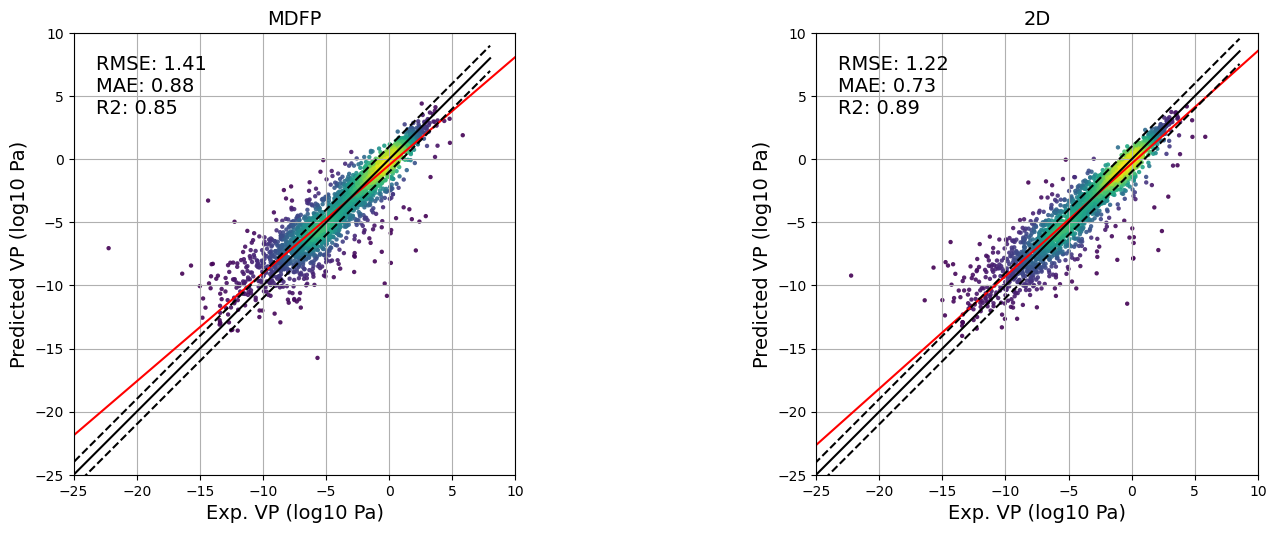

In [10]:
#plot these two
density_plot_multiple(reals = [df_preds['vp'],df_preds['vp']],predictions=[df_preds['pred_mdfp'],df_preds['pred_2d']],titles = ['MDFP','2D'],bounds=[-25,10])

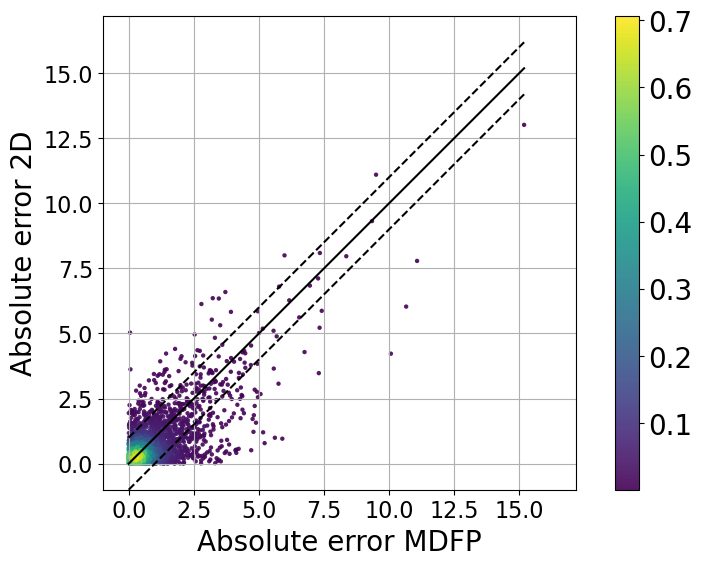

In [11]:
import matplotlib.pyplot as plt

fsize = 20
real = df_preds['abs_error_mdfp'].tolist()
prediction = df_preds['abs_error_2d'].tolist()
fig = plt.figure(1, figsize=(10, 6.15))
ax = plt.subplot(111)
lower = -1
upper = max(prediction + real) + 2
x = np.linspace(lower, upper,len(real))
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)-1, max(prediction + real) - 1], 'k--')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)+1, max(prediction + real)+1], 'k--')

import statsmodels.api as sm
dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction],var_type='cc', bw='normal_reference')
z = dens_u.pdf([real, prediction])

sc = plt.scatter(real, prediction, lw=0, c=z, s=10, alpha = 0.9)

cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=fsize)

plt.xlabel(r'Absolute error MDFP', fontsize=fsize)
plt.ylabel(r'Absolute error 2D', fontsize=fsize)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.grid(1,"both")
plt.axis([lower, upper, lower, upper])
#make square
ax.set_aspect('equal', 'box')
plt.show()

In [12]:
#get df for points were mdfp is better then 2d
df_mdfp_better = df_preds[df_preds['abs_error_mdfp'] < df_preds['abs_error_2d']]
print(len(df_mdfp_better))
df_mdfp_better
molregnos_mdfp_better = df_mdfp_better.index.tolist()

1287


In [13]:
df_mdfp_better #sort by where abs_error_mdfp is most smaller then abs_error_2d
df_mdfp_better = df_mdfp_better.sort_values(by=['abs_error_mdfp'])
df_mdfp_better

,vp,pred_mdfp,pred_2d,abs_error_mdfp,abs_error_2d
molregno,,,,,
2782,-4.744727,-4.744841,-3.946617,0.000114,0.798110
4088,-2.975442,-2.975664,-2.669441,0.000223,0.306001
3679,-0.852932,-0.852552,-0.767950,0.000379,0.084982
99,-3.050322,-3.049737,-2.809911,0.000584,0.240411
550,-5.930000,-5.930647,-5.765417,0.000647,0.164583
...,...,...,...,...,...
1034,0.162328,-5.612693,-6.636268,5.775021,6.798596
535,0.120537,-5.861460,-7.876270,5.981997,7.996807
3139,-2.771294,-8.934660,-9.042356,6.163365,6.271061


In [14]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()
cur.execute("SELECT * FROM cs_mdfps_schema.experimental_data WHERE molregno IN %s", (tuple(molregnos_mdfp_better),))
data = cur.fetchall()
smiles = [x[4]['SMILES'] for x in data]

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


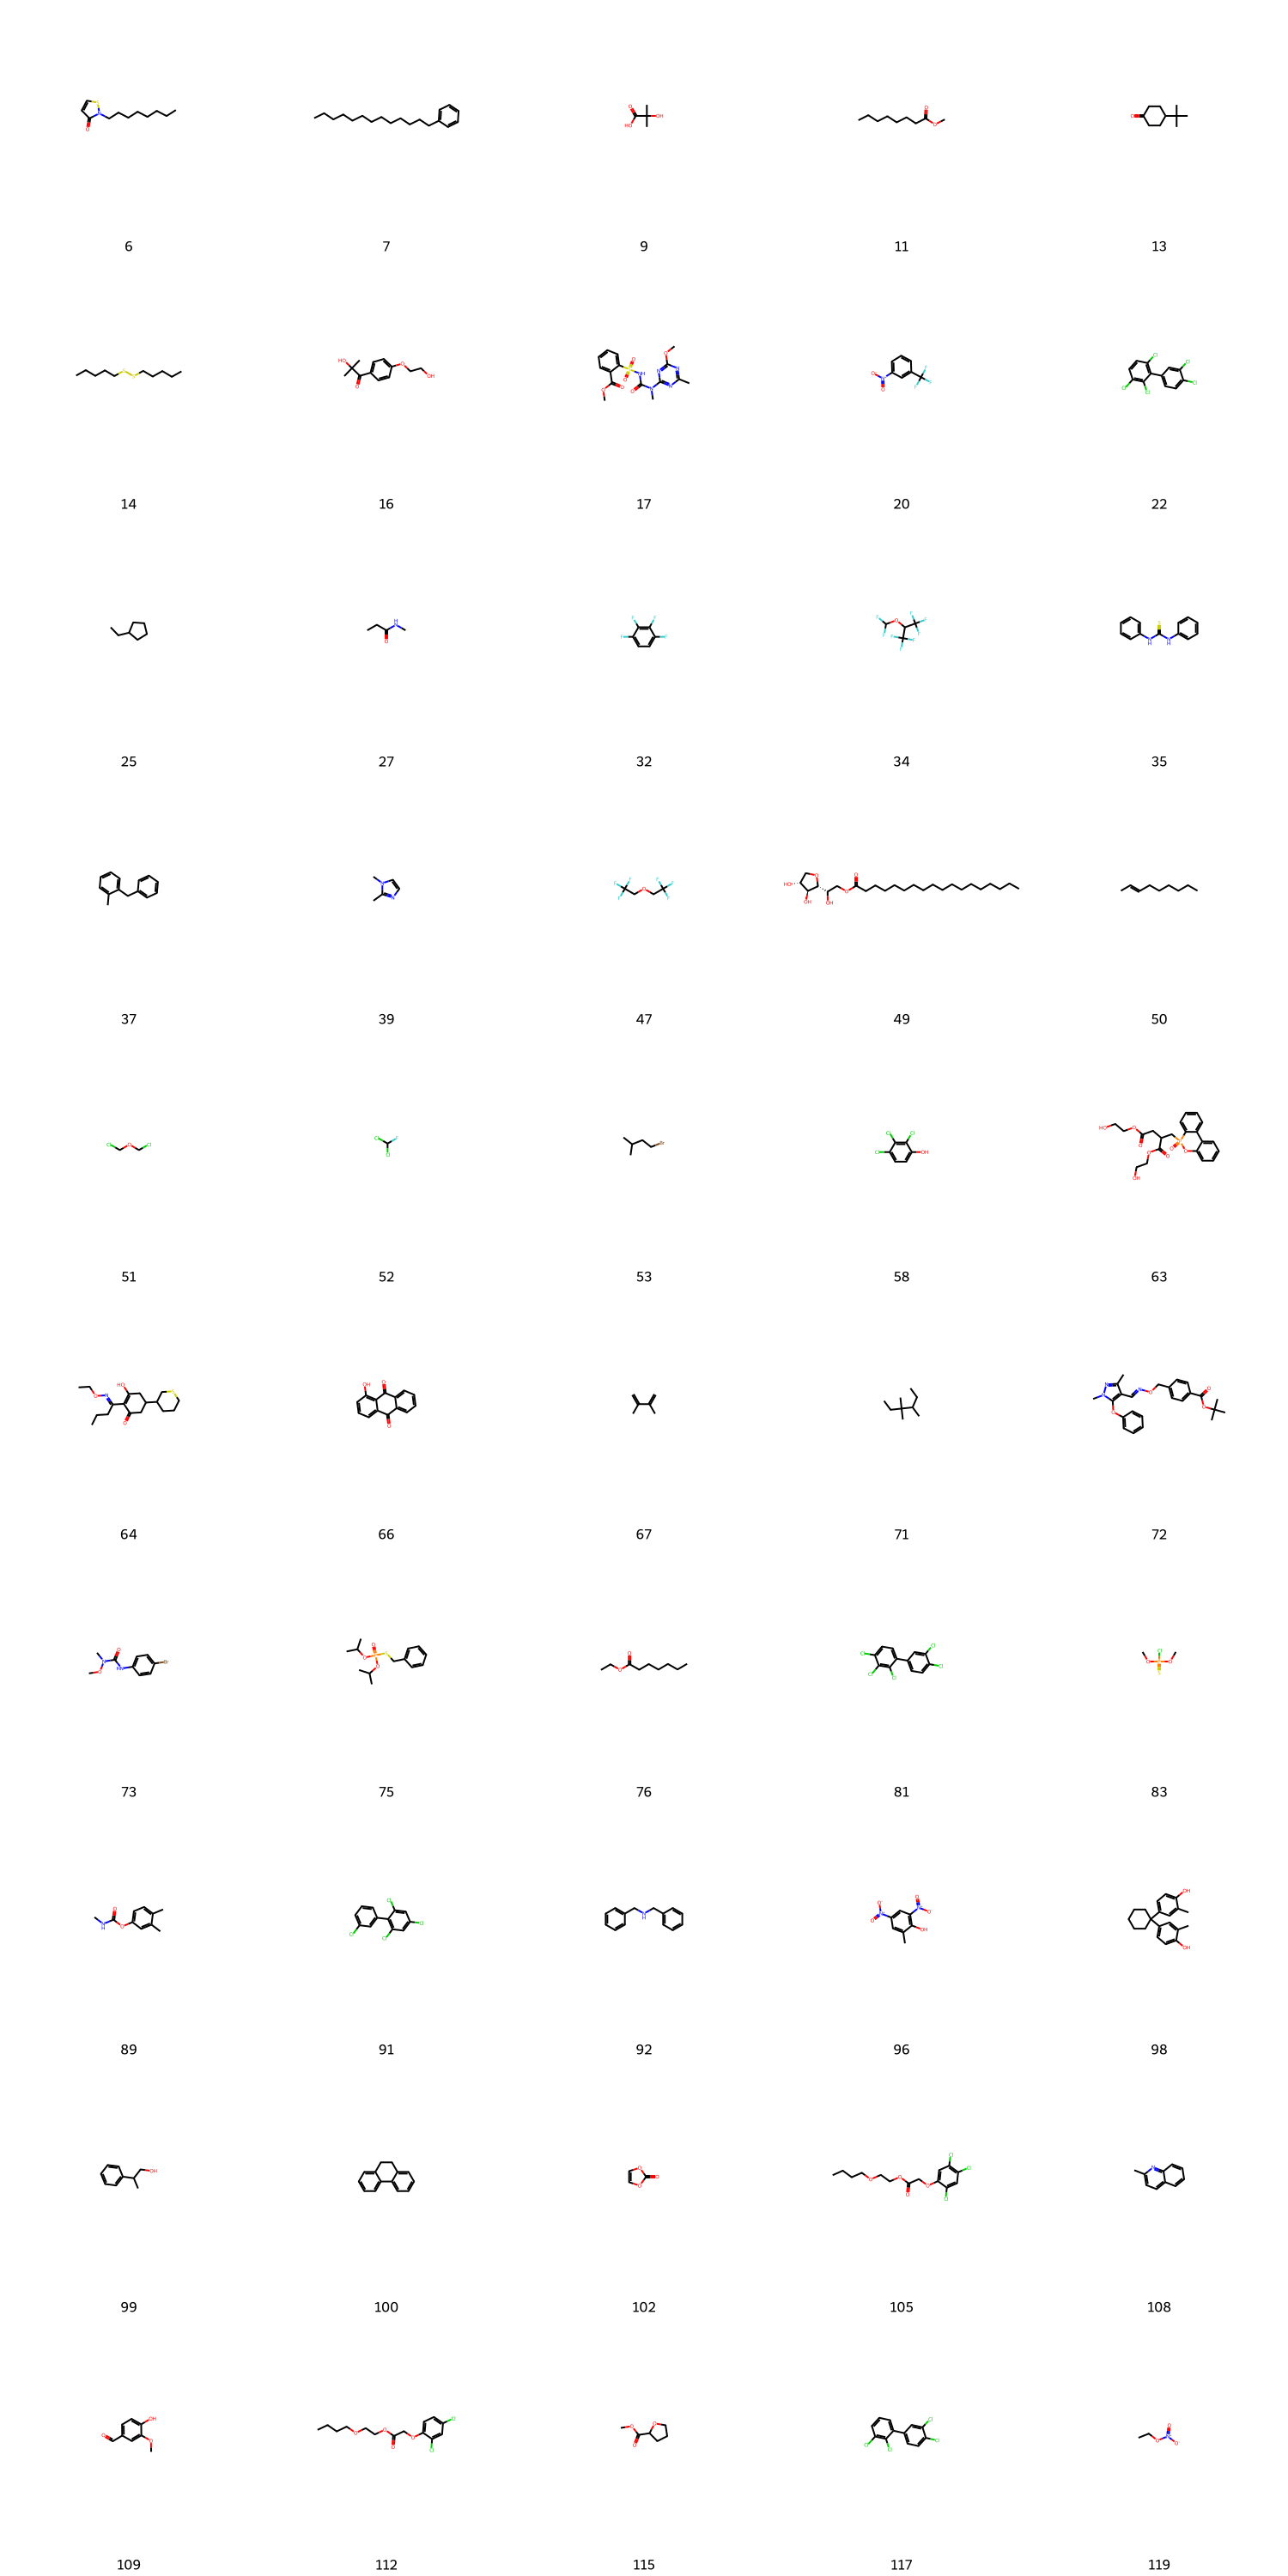

In [15]:
mols = [Chem.MolFromSmiles(s) for s in smiles]
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(300,300), legends=[str(x) for x in molregnos_mdfp_better])

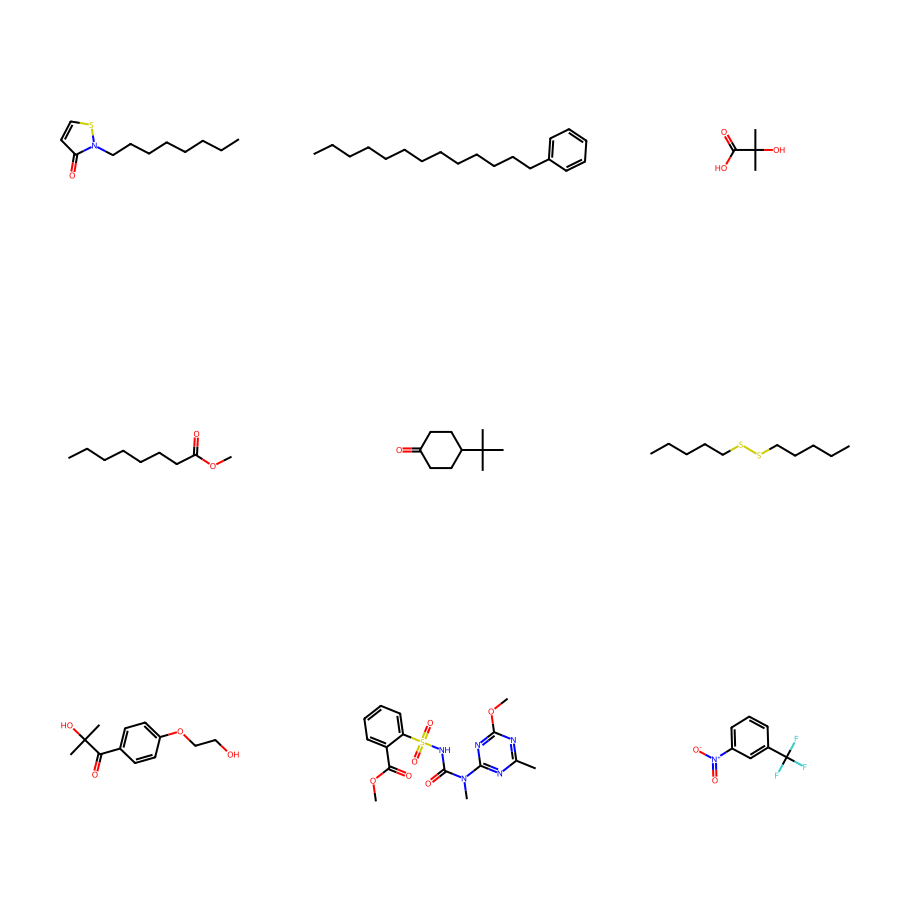

In [16]:
mols = [Chem.MolFromSmiles(s) for s in smiles]
molregnos 
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols[:9], molsPerRow=3, subImgSize=(300,300))

Text(0.5, 1.0, 'Number of molecules per bin of experimental vp values')

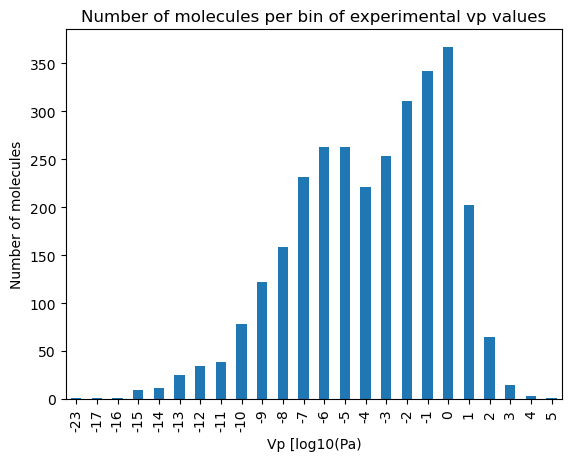

In [17]:
#look at difference in prediction error per bin of experimental vp values. Bin per 1 log unit
df_preds['vp_bin'] = np.floor(df_preds['vp'])
df_preds['vp_bin'] = df_preds['vp_bin'].astype(int)
df_preds['vp_bin'].value_counts()
df_preds['vp_bin'].value_counts().sort_index()
df_preds['vp_bin'].value_counts().sort_index().plot.bar()
plt.ylabel('Number of molecules')
plt.xlabel('Vp [log10(Pa)')
plt.title('Number of molecules per bin of experimental vp values')


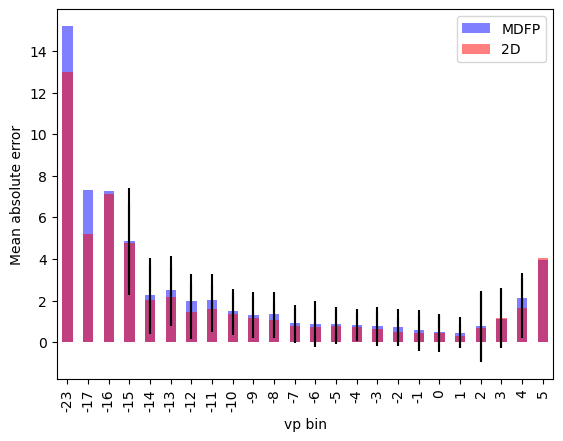

In [18]:
import matplotlib.pyplot as plt

# assuming df_preds is your DataFrame
fig, ax = plt.subplots()
mean_mdfp = df_preds['abs_error_mdfp'].groupby(df_preds['vp_bin']).mean()
std_mdfp = df_preds['abs_error_mdfp'].groupby(df_preds['vp_bin']).std()
mean_2d = df_preds['abs_error_2d'].groupby(df_preds['vp_bin']).mean()
std_2d = df_preds['abs_error_2d'].groupby(df_preds['vp_bin']).std()
datapoints = df_preds['abs_error_2d'].groupby(df_preds['vp_bin']).count()
mean_mdfp.plot.bar(ax=ax, color='blue', alpha=0.5, yerr=std_mdfp)
mean_2d.plot.bar(ax=ax, color='red', alpha=0.5, yerr=std_2d)
ax.legend(['MDFP','2D'])
ax.set_xlabel('vp bin')
ax.set_ylabel('Mean absolute error')
plt.show()

/tmp/ipykernel_3795934/1316450871.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  mean_mdfp_percentages = [mean_mdfp[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
/tmp/ipykernel_3795934/1316450871.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  std_mdfp_percentages = [std_mdfp[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
/tmp/ipykernel_3795934/1316450871.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  mean_2d_percentages = [mean_2d[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
/tmp/ipykernel_3795934/1316450871.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  std_2d_percentages = [std_2d[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3680: RuntimeWarning: invalid value encountered in sc

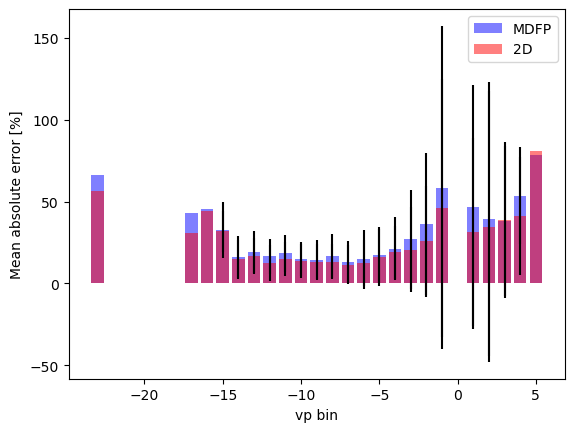

In [19]:
mean_mdfp.index[0]
mean_mdfp_percentages = [mean_mdfp[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
std_mdfp_percentages = [std_mdfp[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
mean_2d_percentages = [mean_2d[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
std_2d_percentages = [std_2d[mean_mdfp.index[i]] /mean_mdfp.index[i] * 100 for i in range(len(mean_mdfp))]
std_2d_percentages = [abs(x) for x in std_2d_percentages]
std_mdfp_percentages = [abs(x) for x in std_mdfp_percentages]
mean_mdfp_percentages = [abs(x) for x in mean_mdfp_percentages]
mean_2d_percentages = [abs(x) for x in mean_2d_percentages]
#barplot
import matplotlib.pyplot as plt
plt, ax = plt.subplots()
ax.bar(mean_mdfp.index, mean_mdfp_percentages, yerr=std_mdfp_percentages, color='blue', alpha=0.5)
ax.bar(mean_2d.index, mean_2d_percentages, yerr=std_2d_percentages, color='red', alpha=0.5)
ax.legend(['MDFP','2D'])
ax.set_xlabel('vp bin')
ax.set_ylabel('Mean absolute error [%]')
# for i, v in enumerate(datapoints):
#     x = mean_2d.index[i]
#     y = mean_mdfp_percentages[i]
#     if str(std_mdfp_percentages[i]) != "nan":
#         y += std_mdfp_percentages[x]
#     ax.text(x, y, str(v), color='black', fontweight='bold', ha='center', va='bottom',fontsize=6)

plt.show()

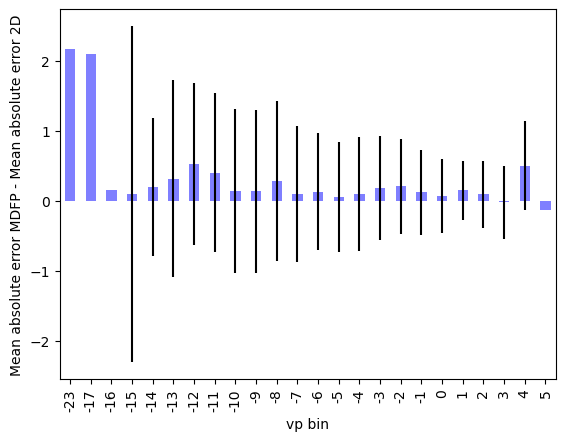

In [20]:
import matplotlib.pyplot as plt

# assuming df_preds is your DataFrame
fig, ax = plt.subplots()
mean_diff = (df_preds['abs_error_mdfp'] - df_preds['abs_error_2d']).groupby(df_preds['vp_bin']).mean()
std_diff = (df_preds['abs_error_mdfp'] - df_preds['abs_error_2d']).groupby(df_preds['vp_bin']).std()
datapoints = (df_preds['abs_error_mdfp'] - df_preds['abs_error_2d']).groupby(df_preds['vp_bin']).count()
mean_diff.plot.bar(ax=ax, color='blue', alpha=0.5, yerr=std_diff)
ax.set_xlabel('vp bin')
ax.set_ylabel('Mean absolute error MDFP - Mean absolute error 2D')
plt.show()

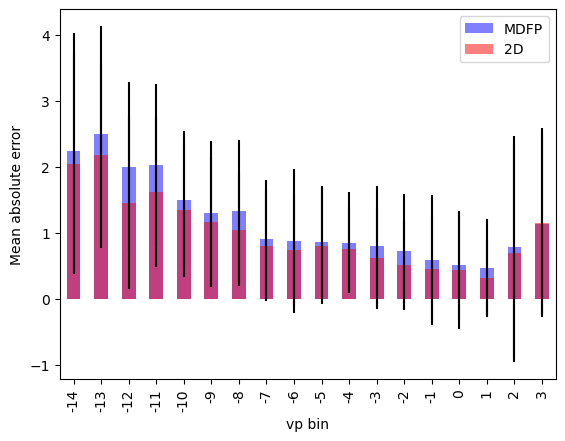

In [21]:
#look only at data with >10 datapoints per bin
#count datapoints per bin
datapoints = df_preds['abs_error_2d'].groupby(df_preds['vp_bin']).count()
bins_with_10_datapoints = datapoints[datapoints > 10].index.tolist()    

import matplotlib.pyplot as plt
#plot only bins with >10 datapoints
# assuming df_preds is your DataFrame
fig, ax = plt.subplots()
df_preds_10 = df_preds[df_preds['vp_bin'].isin(bins_with_10_datapoints)]
mean_mdfp = df_preds_10['abs_error_mdfp'].groupby(df_preds_10['vp_bin']).mean()
std_mdfp = df_preds_10['abs_error_mdfp'].groupby(df_preds_10['vp_bin']).std()
mean_2d = df_preds_10['abs_error_2d'].groupby(df_preds_10['vp_bin']).mean()
std_2d = df_preds_10['abs_error_2d'].groupby(df_preds_10['vp_bin']).std()
datapoints = df_preds_10['abs_error_2d'].groupby(df_preds_10['vp_bin']).count()
mean_mdfp.plot.bar(ax=ax, color='blue', alpha=0.5, yerr=std_mdfp)
mean_2d.plot.bar(ax=ax, color='red', alpha=0.5, yerr=std_2d)
ax.legend(['MDFP','2D'])
ax.set_xlabel('vp bin')
ax.set_ylabel('Mean absolute error')
plt.show()


